# WeatherPy

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats =['retina']

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import pycountry
import seaborn as sns
from scipy.stats import linregress
from matplotlib.pylab import rcParams

sns.set()
plt.rc('lines', linewidth=1)
rcParams['figure.figsize'] = 12,6

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

# Set the data display options in a float format
pd.options.display.float_format = '{:,.2f}'.format

## Generate Cities List

In [3]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
print('Number of unique cities', len(cities))

# Creating random dataset for testing
test_cities = np.random.choice(cities, 100)
print('Random array of 100 cities for testing:', [test_cities[i].title() for i in range(len(test_cities))])

Number of unique cities 635
Random array for testing: ['Saiki', 'Bjorkelangen', 'Casian', 'Udayagiri', 'Port Lincoln', 'Kikwit', 'Coahuayana', 'Arari', 'Cap Malheureux', 'Wewak', 'Kailua', 'Dunedin', 'Kailua', 'Balkanabat', 'Rosarito', 'Krasnoselkup', 'Kalianget', 'East London', 'Bonney Lake', 'Dauphin', 'Marcona', 'Yellowknife', 'Puerto Madero', 'Kutina', 'Sarangani', 'Carnarvon', 'Yellowknife', 'Shetpe', 'Aksu', 'Cap Malheureux', 'Kinanah', 'Grand Centre', 'Toulepleu', 'Lavrentiya', 'Shahreza', 'Tarakan', 'Alta Floresta', 'Topolog', 'Mareeba', 'Nhulunbuy', 'Ahipara', 'Nguiu', 'Gaoua', 'Port Hedland', 'Garbolovo', 'Lolua', 'Port-Cartier', 'Kristiinankaupunki', 'Tiruchchendur', 'Mtwara', 'Mahebourg', 'Eyl', 'Bilibino', 'Bolshiye Chapurniki', 'Sandnessjoen', 'Harindanga', 'Etchoropo', 'Hamilton', 'Coyah', 'Tautira', 'Paraiso', 'Arraial Do Cabo', 'Zambezi', 'Norman Wells', 'Keffi', 'Kontagora', 'Payo', 'Nemuro', 'Hasaki', 'Aracati', 'Waipawa', 'Salina', 'Bonney Lake', 'Samalaeulu', 'Coll

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [4]:
# Save config information.
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "metric"

# Build partial query URL
query_url = f"{url}appid={weather_api_key}&units={units}&q="

# set up lists to hold reponse info
lat = []
lon = []
temp_max = []
humidity = []
cloudiness = []
wind_speed = []
country = []
date = []
found_cities = []
not_found_cities = []
requests.get(query_url + cities[0]).json()

{'cod': '404', 'message': 'city not found'}

In [5]:
# Loop through the list of cities and perform a request for data on each
print('Beginning data retrieval for ', len(cities), ' cities\n')
for city in cities:
    response = requests.get(query_url + city).json()
#    print ('Processing request for city:', city)
    try:
        lat.append(response['coord']['lat'])
        lon.append(response['coord']['lon'])
        temp_max.append(response['main']['temp_max'])
        humidity.append(response['main']['humidity'])
        cloudiness.append(response['clouds']['all'])
        wind_speed.append(response['wind']['speed'])
        country.append(response['sys']['country'])
        date.append(response['dt'])
        found_cities.append(city)
    except:
        not_found_cities.append(city)
        pass
    if len(found_cities) % 40 == 0: 
        print('Processing records: found ', len(found_cities),' cities, skipped ', len(not_found_cities), 'cities')
print('\nData retrieval is over\n')
print('Number of skipped cities = ', len(not_found_cities))
print([not_found_cities[i].title() for i in range(len(not_found_cities))])

Beginning data retrieval for  635  cities

Processing records: found  0  cities, skipped  1 cities
Processing records: found  40  cities, skipped  4 cities
Processing records: found  80  cities, skipped  9 cities
Processing records: found  120  cities, skipped  11 cities
Processing records: found  160  cities, skipped  15 cities
Processing records: found  200  cities, skipped  17 cities
Processing records: found  200  cities, skipped  18 cities
Processing records: found  240  cities, skipped  21 cities
Processing records: found  240  cities, skipped  22 cities
Processing records: found  240  cities, skipped  23 cities
Processing records: found  280  cities, skipped  26 cities
Processing records: found  320  cities, skipped  30 cities
Processing records: found  360  cities, skipped  36 cities
Processing records: found  360  cities, skipped  37 cities
Processing records: found  400  cities, skipped  41 cities
Processing records: found  440  cities, skipped  44 cities
Processing records: 

In [6]:
# create a data dict from found_cities, lat, lon, temp_max, humidity, cloudiness, wind_speed, country
weather_dict = {
    "City": found_cities,
    "Lat": lat,
    "Lng": lon,
    "Max Temp": temp_max,
    "Humidity": humidity,
    "Cloudiness": cloudiness,
    "Wind Speed": wind_speed,
    "Country Code": country
                }

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [7]:
def country_flag(df):
    if (len(df['Country Code'])==2 and df['Country Code'] in list_alpha_2):
        return pycountry.countries.get(alpha_2=df['Country Code']).name
    else:
        return 'Invalid Code'

In [8]:
# create a data frame from data dict
weather_data = pd.DataFrame(weather_dict)
weather_data['City'] = weather_data['City'].map(str.upper)  
list_alpha_2 = [i.alpha_2 for i in list(pycountry.countries)]
weather_data['Country Name'] = weather_data.apply(country_flag, axis = 1)
weather_data['Date'] = date
weather_data.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country Code,Country Name,Date
0,KHATANGA,71.97,102.50,19.13,52,14,5.75,RU,Russian Federation,1594681195
1,SAO JOAO DA BARRA,-21.64,-41.05,22.59,75,7,3.54,BR,Brazil,1594681187
2,KAPAA,22.08,-159.32,26.67,88,75,7.20,US,United States,1594681137
3,NANTUCKET,41.28,-70.10,22.78,100,90,2.60,US,United States,1594681481
4,RIKITEA,-23.12,-134.97,22.83,85,45,5.50,PF,French Polynesia,1594681169


In [9]:
weather_data.count()

City            575
Lat             575
Lng             575
Max Temp        575
Humidity        575
Cloudiness      575
Wind Speed      575
Country Code    575
Country Name    575
Date            575
dtype: int64

In [10]:
weather_data.describe()

,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,575.00,575.00,575.00,575.00,575.00,575.00,575.00
mean,19.30,23.43,20.12,71.78,49.32,3.29,"1,594,681,610.68"
std,33.23,88.32,7.76,20.05,37.44,2.35,252.98
min,-54.80,-179.17,0.00,3.00,0.00,0.03,"1,594,680,879.00"
25%,-7.28,-53.52,14.15,62.00,7.50,1.50,"1,594,681,492.00"
50%,21.58,29.09,21.46,76.00,49.00,2.60,"1,594,681,767.00"
75%,48.30,93.70,26.00,87.50,86.50,4.60,"1,594,681,790.50"
max,78.22,179.32,42.00,100.00,100.00,12.30,"1,594,681,814.00"


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [11]:
high_humidity = weather_data[weather_data['Humidity']>=100]
high_humidity

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country Code,Country Name,Date
3,NANTUCKET,41.28,-70.10,22.78,100,90,2.60,US,United States,1594681481
8,SALALAH,17.02,54.09,27.00,100,90,4.10,OM,Oman,1594681266
30,YELLOWKNIFE,62.46,-114.35,15.00,100,75,6.20,CA,Canada,1594681176
45,MOUNT GAMBIER,-37.83,140.77,3.00,100,0,2.18,AU,Australia,1594681557
61,KLAKSVIK,62.23,-6.59,10.00,100,98,2.60,FO,Faroe Islands,1594681568
76,BINTULU,3.17,113.03,23.00,100,40,2.33,MY,Malaysia,1594681604
83,BRAE,60.40,-1.35,11.00,100,98,4.60,GB,United Kingdom,1594681208
106,CARNARVON,-24.87,113.63,16.00,100,90,2.10,AU,Australia,1594681174
174,SAIKI,32.95,131.90,22.00,100,75,2.60,JP,Japan,1594681769
184,HASAKI,35.73,140.83,22.00,100,75,2.60,JP,Japan,1594681199


In [12]:
#  Get the indices of cities that have humidity over 100%.
index_label = weather_data.query('Humidity >=100').index.tolist() 
print(index_label, sep=',')

[3, 8, 30, 45, 61, 76, 83, 106, 174, 184, 188, 212, 257, 266, 333, 380, 409, 472, 513]


In [13]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
clean_city_data = weather_data.drop(index_label, axis=0, inplace=False)
clean_city_data.shape

(556, 10)

In [14]:
# Export the City_Data into a csv
clean_city_data.to_csv(output_data_file, index=False) 

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [15]:
lat = clean_city_data['Lat']
tem = clean_city_data['Max Temp']
hum = clean_city_data['Humidity']
cld = clean_city_data['Cloudiness']
wnd = clean_city_data['Wind Speed']

## Latitude vs. Temperature Plot

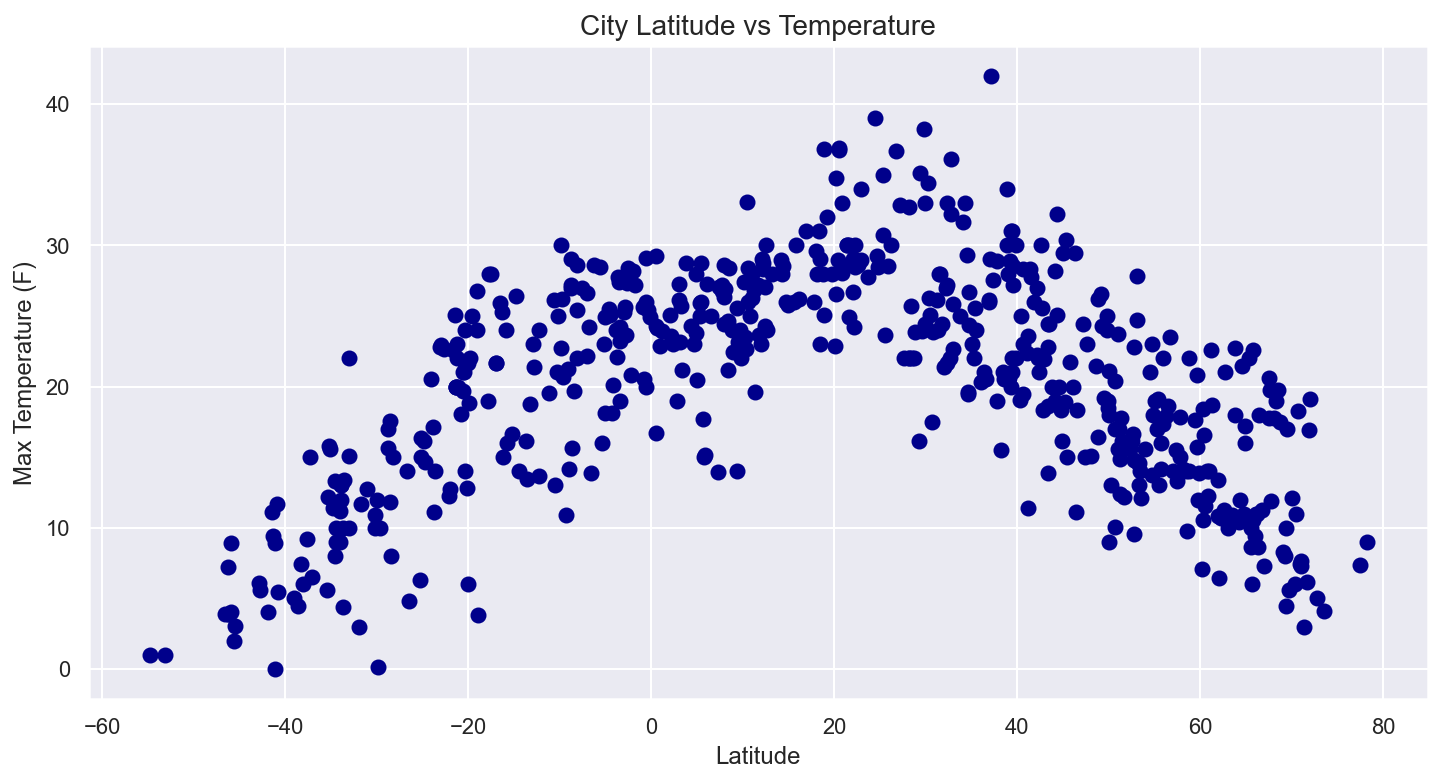

In [16]:
_= plt.plot(lat, tem, marker='.', markersize=14, color='darkblue', linestyle='none')
_ = plt.xlabel('Latitude')
_ = plt.ylabel('Max Temperature (F)')
_ = plt.title('City Latitude vs Temperature', size=14)

## Latitude vs. Humidity Plot

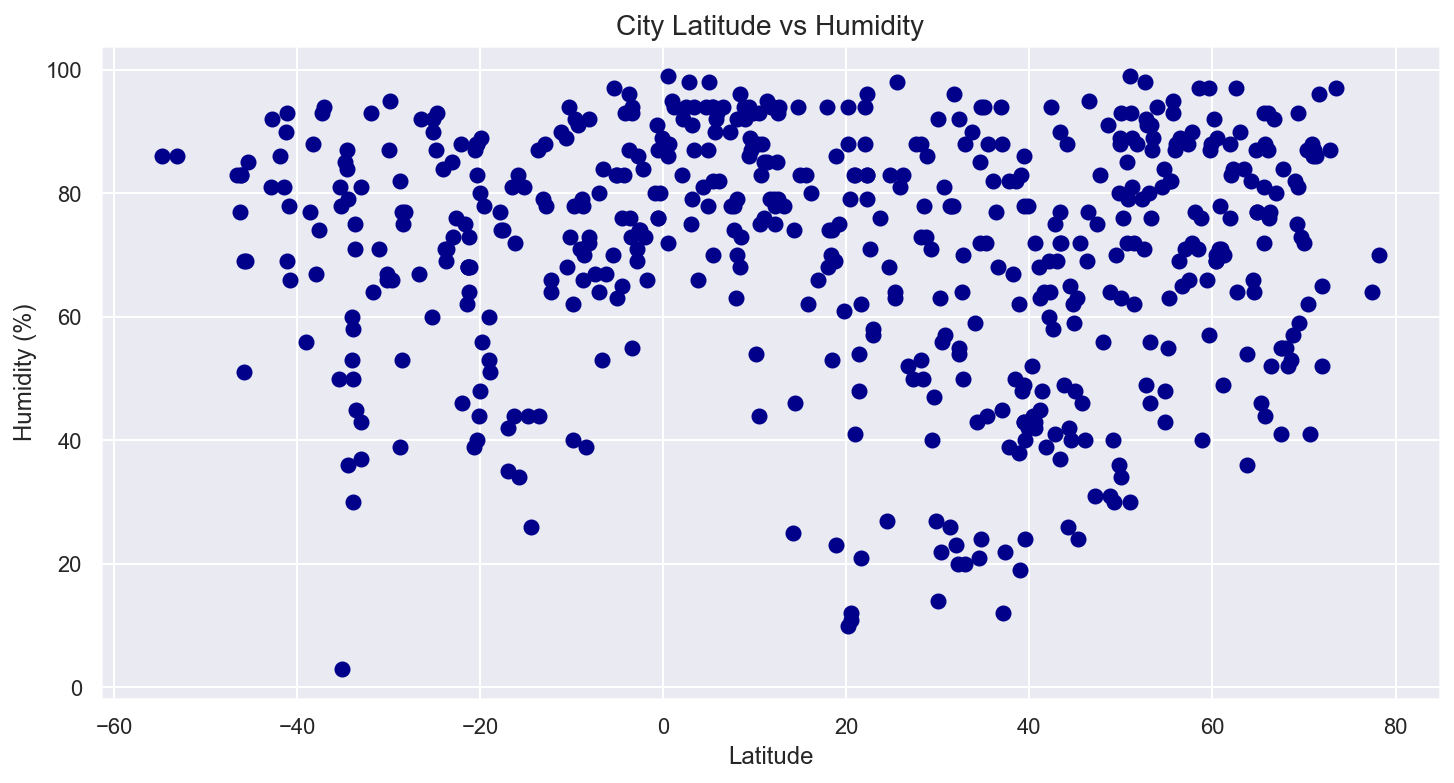

In [17]:
_= plt.plot(lat, hum, marker='.', markersize=14, color='darkblue', linestyle='none')
_ = plt.xlabel('Latitude')
_ = plt.ylabel('Humidity (%)')
_ = plt.title('City Latitude vs Humidity', size=14)

## Latitude vs. Cloudiness Plot

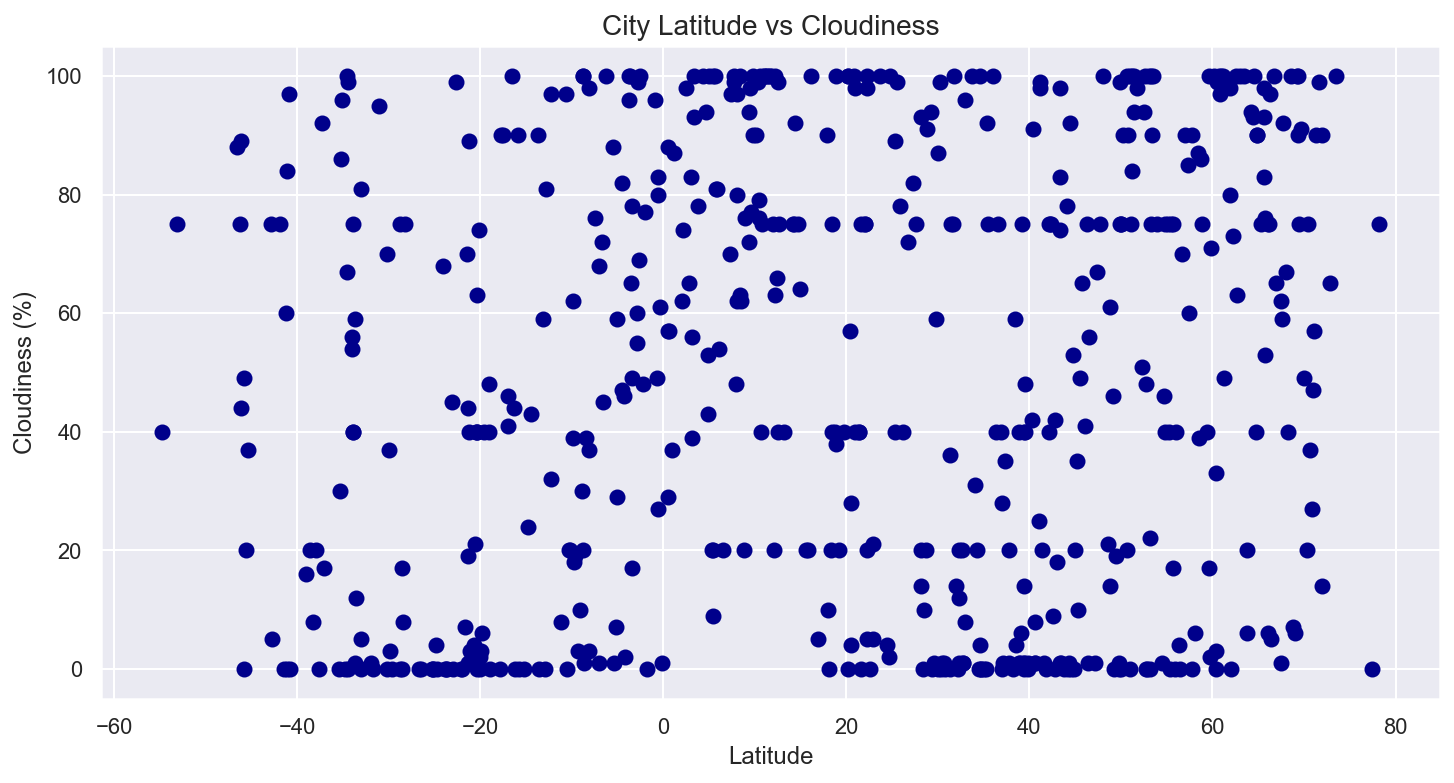

In [18]:
_= plt.plot(lat, cld, marker='.', markersize=14, color='darkblue', linestyle='none')
_ = plt.xlabel('Latitude')
_ = plt.ylabel('Cloudiness (%)')
_ = plt.title('City Latitude vs Cloudiness', size=14)

## Latitude vs. Wind Speed Plot

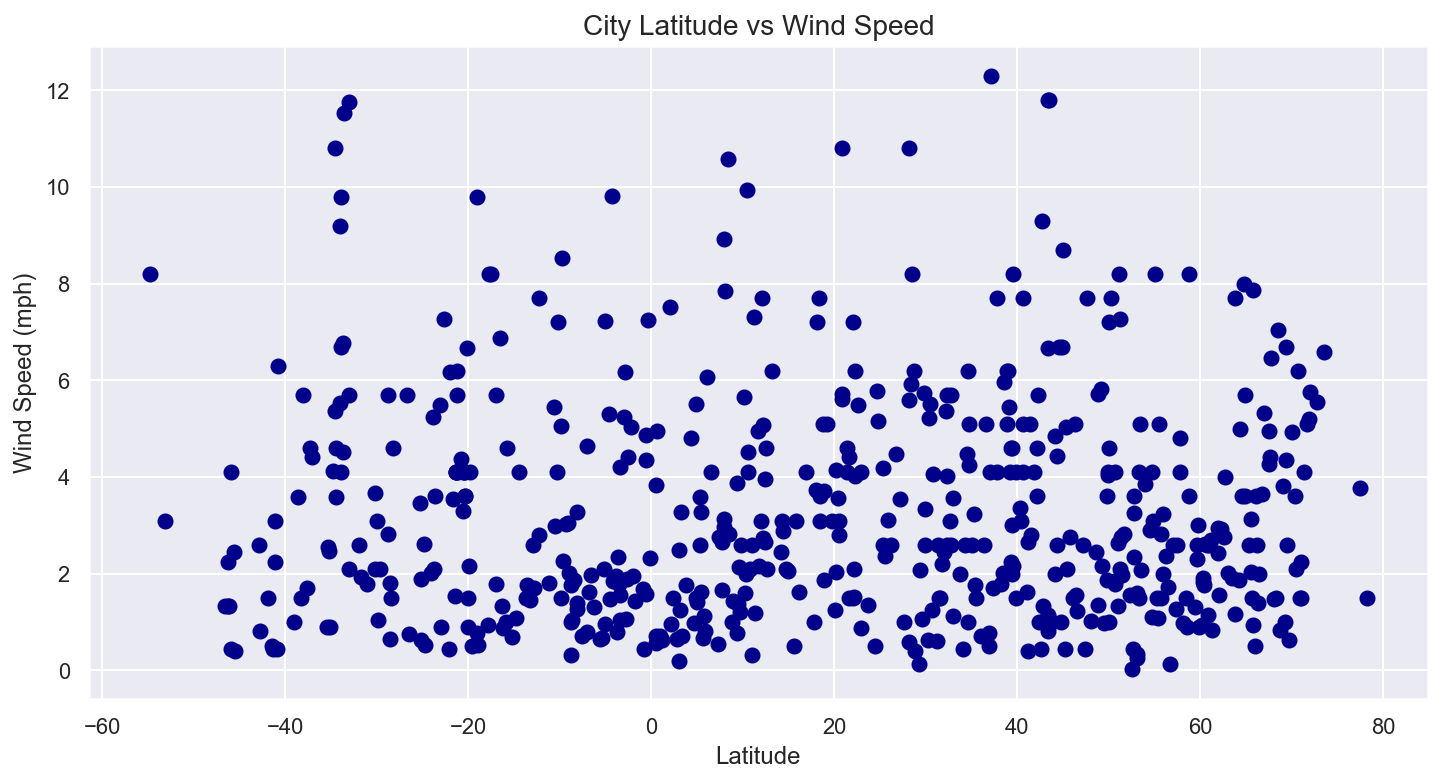

In [19]:
_= plt.plot(lat, wnd, marker='.', markersize=14, color='darkblue', linestyle='none')
_ = plt.xlabel('Latitude')
_ = plt.ylabel('Wind Speed (mph)')
_ = plt.title('City Latitude vs Wind Speed', size=14)

## Linear Regression

In [20]:
# OPTIONAL: Create a function to create Linear Regression plots

In [21]:
# Create Northern and Southern Hemisphere DataFrames

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression